## Run ANL's LOM, QUIC, for Height analysis

Jenna Ruzekowicz (jenna.ruzekowicz@nrel.gov), Caleb Phillips (caleb.phillips@nrel.gov), and Dmitry Duplyakin (dmitry.duplyakin@nrel.gov)

The purpose of this notebook is to read in inflow data and run the LOMs.

Output is saved into files named:

 > `bergey|oneenergy_anl|lanl_tid_windSource.csv.bz2`, where `windSource` is one of: `wtk`, `wtk_led_2018`, `wtk_led_2019`, `wtk_bc` (`bc` referes to bias corrected versions) 

### Work notes:

- Working on runnng LANL's QUIC model
- Sites t007 and t074 are currently excluded becuase they don't have height data matching other sites
- Code looks for `"%s/%sv2.json" % (obstacle_data_dir, tid)` files for site obstacles inside `02 Input For Models` dir
- Sites t207 take a very long time! (slowest site)
- Notice that based on the plots at the end of the notebook ws-adjusted = ws (exactly) for quite a few sites. No negative ws-adjusted values observed yet for this set of inputs.
- `wind_sources = ["wtk", "wtk_led_2019", "wtk_bc"]` -- not including "wtk_led_2018" yet becuase 5-minuted data for 2018 is very large and processing will be slower than for other options here; will add it for final/more complete processing
- `overwrite` (if not set) flag allows to skip processing previously studied site x wind_source combinations (if output files with matching names are found)

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import matplotlib.pyplot as plt
from dw_tap.lom import run_lom
import os
import seaborn as sns
import glob
from dw_tap.data_processing import _LatLon_To_XY, filter_obstacles
from dw_tap.data_processing import wind_binning
import subprocess
import shutil
from shapely.geometry import Polygon, Point, MultiPolygon
from pyproj import Proj, transform

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
index = pd.read_csv("01 Bergey Turbine Data/bergey_sites.csv")
index.head()

,APRS ID,AID,Public Site Name,Internal Site Name,State,Latitude,Longitude,Hub Height (m),Lidar Quality,Lidar Collection Year,...,Building Data Quality,Turbine,Periods with Consistent Generation Data,Met Tower,Met Tower Latitude,Met Tower Longitude,Measurement Height (m),Measurement Privacy,Bergey Annual Average Wind Speed (m/s),Bergey Generation (kWh) (0% Loss Assumption)
0,t007,A2744,Fremont,Fremont,MN,43.918622,-91.899498,41,N/A (Legacy Data),NaN,...,"Partial, some missing",Bergey Excel 10,2012/01 - 2013/12 (outage starting mid-2013/11...,mn_prairiestar.PROPRIETARY.pruf.csv,43.673,-92.698,50.0,Proprietary,6.55,24828
1,t024,A2690,Washoe,Thomas Danzinger,NV,39.331088,-119.820230,30,QL1,2020.0,...,Good coverage,Bergey Excel 10,2011/01 - 2022/12,NaN,NaN,NaN,NaN,NaN,5.86,19184
2,t028,A2672,Towamensing,Derr,PA,40.851353,-75.598395,30,QL2,2019.0,...,"Partial, some missing",Bergey Excel 10,2011/01 - 2022/12,NaN,NaN,NaN,NaN,NaN,4.60,9670
3,t034,A3685,Lycoming,Dan Poor,NY,43.524158,-76.372290,31,QL2,2018.0,...,Good coverage,Bergey Excel 10,"2013/01 - 2017/12, 2019/01 - 2021/12",ny_oswego.qc.csv,43.464,-76.511,15.0,Public,6.55,24828
4,t041,A3933,Rockford,Fossil Park,IA,43.047418,-92.981674,37,QL2,2020.0,...,Good coverage,Bergey Excel 10,"2013/01 - 2013/12, 2015/01 - 2022/12",NaN,NaN,NaN,NaN,NaN,5.94,19829


### Select which sites need to be processed and wind data source

In [3]:
# Small test with several sites
selected = ["t169"] #"t207"] # ["t169"]

# Process all sites:
#selected = index["APRS ID"].tolist()

# Remove 2 sites that currently don't have obstacle descriptions with the heights based on lidar data
#selected = [x for x in selected if not(x in ["t007", "t074"])]

#selected = [x for x in selected if not(x in ["t221"])]

print(selected)

wind_sources = ["wtk_rh_analysis"] # Choices here: "wtk", "wtk_led_2018", "wtk_led_2019", "wtk_bc"

obstacle_modes = ["bldgsonly"] #"bldgsonly_100m", "bldgsonly"] #["bldgsonly", "bldgsonly_100m"]

['t169']


### Load wind data

In [4]:
# Get inversemoninobukhovlength_2m for each site (average only)

inversemoninobukhovlength_2m = {}

wtk_df = pd.read_csv("01 Bergey Turbine Data/wtk.csv.bz2")

for tid in selected:
    df = wtk_df[wtk_df["tid"] == tid].reset_index(drop=True)
    inversemoninobukhovlength_2m[tid] = df["inversemoninobukhovlength_2m"].mean()
    
inversemoninobukhovlength_2m

# Theses inversemoninobukhovlength_2m values will be used for all heights for the selected sites for simplicity, i.e. 
# to eliminate the impact of this factor which isn't well studied otherwise in the current validation

{'t169': 0.017324630808194113}

In [5]:
atmospheric_inputs = {}

for wind_source in wind_sources:

    if wind_source == "wtk_rh_analysis":

        wtk_df = pd.read_csv("01 Bergey RH_analysis/wtk.csv.bz2")

        # Create dict with dataframes that correspond to selected tid's
        dfs_by_tid = {}
        for tid in selected:
            tid_subset = wtk_df[wtk_df["tid"] == tid]
            
            dfs_by_height = {}
            for height in tid_subset.height.unique():
                dfs_by_height[height] = tid_subset[tid_subset["height"] == height].reset_index(drop=True)
                
                # Add in inversemoninobukhovlength_2m
                dfs_by_height[height]["inversemoninobukhovlength_2m"] = inversemoninobukhovlength_2m[tid]
            
            dfs_by_tid[tid] = dfs_by_height
        
        atmospheric_inputs[wind_source] = dfs_by_tid
        
    else:
        print("Unsupported wind_source selected:", wind_source)

In [6]:
# Example input

atmospheric_inputs["wtk_rh_analysis"][selected[0]][40]

,datetime,ws,wd,tid,height,packet_date,inversemoninobukhovlength_2m
0,2007-01-01 00:00:00,9.482897,206.332427,t169,40,2007-01-01 00:00:00+00:00,0.017325
1,2007-01-01 01:00:00,7.704868,205.463003,t169,40,2007-01-01 01:00:00+00:00,0.017325
2,2007-01-01 02:00:00,8.024449,215.905120,t169,40,2007-01-01 02:00:00+00:00,0.017325
3,2007-01-01 03:00:00,8.474017,223.700064,t169,40,2007-01-01 03:00:00+00:00,0.017325
4,2007-01-01 04:00:00,8.414409,219.165514,t169,40,2007-01-01 04:00:00+00:00,0.017325
...,...,...,...,...,...,...,...
8756,2007-12-31 20:00:00,1.844827,149.310988,t169,40,2007-12-31 20:00:00+00:00,0.017325
8757,2007-12-31 21:00:00,2.732742,137.400674,t169,40,2007-12-31 21:00:00+00:00,0.017325
8758,2007-12-31 22:00:00,3.374342,106.189752,t169,40,2007-12-31 22:00:00+00:00,0.017325
8759,2007-12-31 23:00:00,4.281182,96.937253,t169,40,2007-12-31 23:00:00+00:00,0.017325


In [7]:
# Input height for a given tid:

sorted(atmospheric_inputs["wtk_rh_analysis"][selected[0]].keys())

[37, 40, 50, 60, 70, 80]

### Load obstacle data

In [8]:
sites_with_tall_blgs = [] 

obstacle_inputs = {}
for tid in selected:
    
    index_row = index[index["APRS ID"] == tid].iloc[0]
    z_turbine = index_row["Hub Height (m)"]
    
    obstacle_data_dir = "01 Bergey Turbine Data/3dbuildings_geojson"
    obstacle_data_file = "%s/%sv2.json" % (obstacle_data_dir, tid)
    
    if os.path.exists(obstacle_data_file):
        #print("BEFORE filtering (%s):" % obstacle_data_file)
        #display(gpd.read_file(obstacle_data_file))
        
        obstacle_df = filter_obstacles(tid, 
                                       gpd.read_file(obstacle_data_file), 
                                       include_trees=True, 
                                       turbine_height_for_checking=z_turbine)
        obstacle_df["tid"] = tid
        obstacle_inputs[tid] = obstacle_df
        
        #print("AFTER filtering (%s):" % obstacle_data_file)
        #display(obstacle_df)
    else:
        print("Can't access: %s. Skipping" % obstacle_data_file)

all_obstacle_inputs = pd.concat(obstacle_inputs.values())
display(all_obstacle_inputs)

/home/dduplyak/miniconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:327: UserWarning: (tid: t169) Detected at least 1 obstacle that is as tall as the studied turbine:
        height feature_type                                           geometry
1    47.690002     building  POLYGON ((-85.12322 41.07841, -85.12321 41.078...
4    38.265015     building  POLYGON ((-85.12048 41.07932, -85.12047 41.079...
5    37.169983     building  POLYGON ((-85.11821 41.07941, -85.11821 41.079...
20   40.309998     building  POLYGON ((-85.11423 41.07398, -85.11421 41.073...
174  59.519958     building  POLYGON ((-85.11854 41.07733, -85.11854 41.077...
176  43.849976     building  POLYGON ((-85.11506 41.07897, -85.11524 41.078...
177  43.159973     building  POLYGON ((-85.11557 41.07895, -85.11575 41.078...
600  40.349976     building  POLYGON ((-85.11578 41.07669, -85.11577 41.076...
601  43.349976         tree  POLYGON ((-85.11741 41.07765, -85.11744 41.077

,height,geometry,feature_type,tid
0,32.950012,"POLYGON ((-85.11634 41.07768, -85.11633 41.078...",building,t169
1,47.690002,"POLYGON ((-85.12322 41.07841, -85.12321 41.078...",building,t169
2,32.080017,"POLYGON ((-85.12189 41.07936, -85.12207 41.079...",building,t169
3,32.325012,"POLYGON ((-85.12095 41.07940, -85.12115 41.079...",building,t169
4,38.265015,"POLYGON ((-85.12048 41.07932, -85.12047 41.079...",building,t169
...,...,...,...,...
645,20.239990,"POLYGON ((-85.11770 41.07696, -85.11773 41.076...",tree,t169
646,13.140015,"POLYGON ((-85.11781 41.07698, -85.11782 41.076...",tree,t169
647,12.369995,"POLYGON ((-85.11790 41.07700, -85.11792 41.077...",tree,t169
648,17.369995,"POLYGON ((-85.11801 41.07702, -85.11803 41.077...",tree,t169


In [9]:
# Save combined and filtered obstacles dataframe into a file
#obstacle_data_dir = "01 Bergey Turbine Data/3dbuildings_geojson"
#dest_file = "%s/all_obstacles.json" % (obstacle_data_dir)
#all_obstacle_inputs.to_file(dest_file, driver="GeoJSON", index=False)

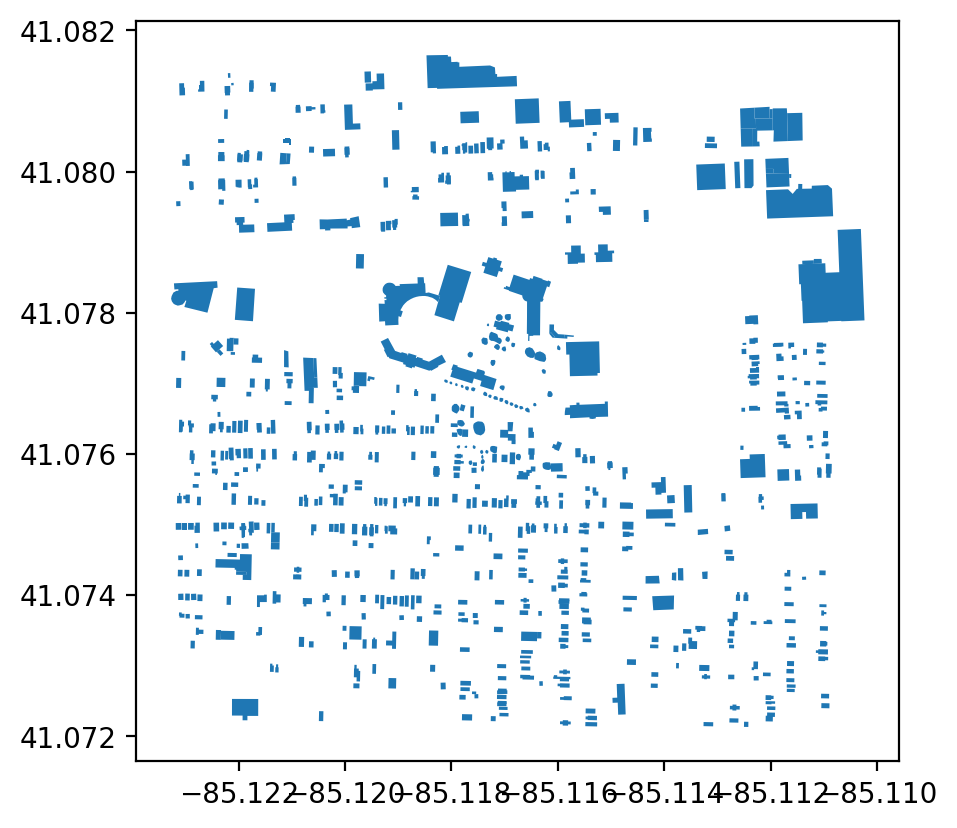

In [10]:
# Quick vis:
for tid, obstacle_df in obstacle_inputs.items():
    obstacle_df.plot()

### Bin wind inputs

In [11]:
dest_dir = "01 Bergey Turbine Data/binned_wind_inputs_h_analysis/"
if os.path.exists(dest_dir):
    shutil.rmtree(dest_dir, ignore_errors=True)
os.makedirs(dest_dir)    
    
# These paths will be passed to QUIC's wrapper script
bins_filepaths = {}
binned_filepaths = {}

for wind_source in wind_sources:
    
    binned_filepaths_curr = {}
    bins_filepaths_curr = {}
    
    binned_filepaths_by_tid = {}
    bins_filepaths_by_tid = {}
    for tid in selected:
        
        heights = sorted(atmospheric_inputs[wind_source][tid].keys())
        
        binned_filepaths_by_height = {}
        bins_filepaths_by_height = {}
        for height in heights:
    
            print("Processing: %s x %s x %s" % (wind_source, tid, height))

            binned_filename = "%s/%s_%s_%s_binned.csv.bz2" % (dest_dir, wind_source, tid, height)
            bins_filename = "%s/%s_%s_%s_bins.csv.bz2" % (dest_dir, wind_source, tid, height)

            # For debugging:
            # atmospheric_inputs[wind_source][tid] -> atmospheric_inputs[wind_source][tid][:X] where X is small
            # to process & save a subset of wind input

            if len(atmospheric_inputs[wind_source][tid][height]) > 0:
                atmospheric_df_binned, atmospheric_bins = \
                    wind_binning(atmospheric_inputs[wind_source][tid][height], wd_bin_width=10.0, ws_bin_width=1.0)

                # Note: atmospheric_df_binned["bin_idx"] will point to indices of the rows in atmospheric_bins

                #display(atmospheric_df_binned)
                #display(atmospheric_bins)

                atmospheric_df_binned.to_csv(binned_filename, index=False)
                print("Saved wind input file (binned):", binned_filename) 
                atmospheric_bins.to_csv(bins_filename, index=False)
                print("Saved wind input file (bins):", bins_filename) 

                #binned_filepaths_curr[tid] = binned_filename
                #bins_filepaths_curr[tid] = bins_filename
                
                binned_filepaths_by_height[height] = binned_filename
                bins_filepaths_by_height[height] = bins_filename

            else: 
                print("wind_source=%s, tid=%s: No atmospheric data found; skipping to the next case." % (wind_source, tid))
                #binned_filepaths_curr[tid] = None
                #bins_filepaths_curr[tid] = None
                
                binned_filepaths_by_height[height] = None
                bins_filepaths_by_height[height] = None
                
        binned_filepaths_by_tid[tid] = binned_filepaths_by_height
        bins_filepaths_by_tid[tid] = bins_filepaths_by_height
            
    binned_filepaths[wind_source] = binned_filepaths_by_tid
    bins_filepaths[wind_source] =  bins_filepaths_by_tid

Processing: wtk_rh_analysis x t169 x 37
Saved wind input file (binned): 01 Bergey Turbine Data/binned_wind_inputs_h_analysis//wtk_rh_analysis_t169_37_binned.csv.bz2
Saved wind input file (bins): 01 Bergey Turbine Data/binned_wind_inputs_h_analysis//wtk_rh_analysis_t169_37_bins.csv.bz2
Processing: wtk_rh_analysis x t169 x 40
Saved wind input file (binned): 01 Bergey Turbine Data/binned_wind_inputs_h_analysis//wtk_rh_analysis_t169_40_binned.csv.bz2
Saved wind input file (bins): 01 Bergey Turbine Data/binned_wind_inputs_h_analysis//wtk_rh_analysis_t169_40_bins.csv.bz2
Processing: wtk_rh_analysis x t169 x 50
Saved wind input file (binned): 01 Bergey Turbine Data/binned_wind_inputs_h_analysis//wtk_rh_analysis_t169_50_binned.csv.bz2
Saved wind input file (bins): 01 Bergey Turbine Data/binned_wind_inputs_h_analysis//wtk_rh_analysis_t169_50_bins.csv.bz2
Processing: wtk_rh_analysis x t169 x 60
Saved wind input file (binned): 01 Bergey Turbine Data/binned_wind_inputs_h_analysis//wtk_rh_analysis_

### Run QUIC

In [12]:
def recover_ts_from_binned(binned_filepath, quic_output_filepath):
    """ Convenience function from going from QUIC output back to "unbinned" timeseries dataframe """ 
    binned_df = pd.read_csv(binned_filepath)
    quic_output = pd.read_csv(quic_output_filepath)
    #display(binned_df)
    binned_df["ws-adjusted"] = binned_df["bin_idx"].apply(lambda bin_idx: quic_output.at[bin_idx, "ws-adjusted"])
    return binned_df

# This flag allows overwriting previously saved files with results if they are found in the specified directory dest_dir 
overwrite = False

# Will be used in the filenames
site_type = "bergey"

# Will be used in the filenames
model_type = "lanl"

dest_dir = "03 Model Outputs/h_analysis/"
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)   
    
quic_raw_output_dir = "03 Model Outputs/quic_raw_outputs/"
if not os.path.exists(quic_raw_output_dir):
    os.makedirs(quic_raw_output_dir)   
    
obs_dir = "01 Bergey Turbine Data/quic_obstacle_files/"
if not os.path.exists(obs_dir):
    os.makedirs(obs_dir)    
    
quic_code_dir ="/campaign/tap/QUIC_TAP_API"
quic_exec = "run_quic_mp_v2.py"
script_path = os.path.join(quic_code_dir, quic_exec)
    
cwd = os.getcwd()

for tid in selected:
    
    row = index[index["APRS ID"] == tid].iloc[0]
    #print(row)
    lat = row["Latitude"]
    lon = row["Longitude"]
    z_turbine = row["Hub Height (m)"]
    xy_turbine = [np.array([lon, lat])]
    
    for obstacle_mode in obstacle_modes:  
    
        curr_obs = all_obstacle_inputs[all_obstacle_inputs["tid"] == tid]
        #display(curr_obs)
        
        if obstacle_mode == "bldgsonly":
            obs_df = curr_obs[curr_obs["feature_type"] == "building"].reset_index(drop=True)
        elif obstacle_mode == "bldgsonly_100m":
            # Assume trees pass the filtering run above in this notebook 
            obs_df = obstacle_inputs[tid] 
            
            print("# of obs (before 100m filtering):", len(obs_df))
            obs_df = filter_obstacles(tid,
                                      obs_df,
                                      include_trees=False, 
                                      turbine_height_for_checking=z_turbine,
                                      limit_to_radius_in_m=100.0,
                                      turbine_lat_lon=(lat, lon))
            print("# of obs (after 100m filtering):", len(obs_df))
                    
        if len(obs_df) == 0:
            print("tid=%s: Obstacle set is empty after filtering. ws-adjusted=ws for these cases." % tid)
            # obs_df.to_file() breaks if empty 
            
            for wind_source in wind_sources:
                heights = sorted(atmospheric_inputs[wind_source][tid].keys())
                for height in heights:
                    dest_filename = "%s/%s_%s_%s_%s_%s_%s.csv.bz2" % (dest_dir, site_type, model_type, tid, wind_source, obstacle_mode, height)
                    if (not overwrite) and (os.path.exists(dest_filename)):
                        print("Found previously saved %s); overwrite flag is off. Skipping to next config." % (dest_filename))
                    else:
                        if bins_filepaths[wind_source][tid][height] == None:
                            print("No atmosperic data found for: wind_source=%s, tid=%s, height=%s" % (wind_source, tid, height))
                            continue
                    recovered_df = atmospheric_inputs[wind_source][tid][height]
                    recovered_df["ws-adjusted"] = recovered_df["ws"]
                    recovered_df.to_csv(dest_filename, index=False)  
                    print("Saved timeseries output:", dest_filename)
                        
            # Skip the following and go to the next tid x obstacle_mode combination
            continue
            
        curr_obs_path = os.path.join(obs_dir, "%s.json" % tid)
        obs_df.to_file(curr_obs_path, driver="GeoJSON", index=False)

        for wind_source in wind_sources:

            heights = sorted(atmospheric_inputs[wind_source][tid].keys())
            for height in heights:
            
                dest_filename = "%s/%s_%s_%s_%s_%s_%s.csv.bz2" % (dest_dir, site_type, model_type, tid, wind_source, obstacle_mode, height)
                if (not overwrite) and (os.path.exists(dest_filename)):
                    print("Found previously saved %s); overwrite flag is off. Skipping to next config." % (dest_filename))
                else:
                    if bins_filepaths[wind_source][tid][height] == None:
                        print("No atmosperic data found for: wind_source=%s, tid=%s, height=%s" % (wind_source, tid, height))
                        continue

                    raw_output_dest = os.path.join(cwd, \
                                                   quic_raw_output_dir, \
                                                   "quic_raw_output_%s_%s_%s_%s.csv.bz2" % (tid, wind_source, obstacle_mode, height))

                    # Must use subprocess as a way of wrapping/calling the python script becuase that script uses multiprocessing
                    # and other methods seem to break
                    subprocess.run(["python", script_path,
                                    "--atmospheric_file", os.path.join(cwd, bins_filepaths[wind_source][tid][height]),
                                    "--obstacles_file", os.path.join(cwd, curr_obs_path),
                                    "--lat", "%f" % lat ,
                                    "--lon", "%f" % lon,
                                    "--z_turbine", "%f" % height,
                                    "--n_chunks", "36",
                                    "--output", raw_output_dest], 
                                   stdout=subprocess.DEVNULL, # This addition suppresses entire (lengthy) output
                                   cwd=quic_code_dir) # This addition is needed to access QUIC executables inside quic_code_dir directory
                    print("Saved raw output:", raw_output_dest)

                    recovered_df = recover_ts_from_binned(os.path.join(cwd, binned_filepaths[wind_source][tid][height]),
                                                          raw_output_dest)

                    # Bring back unbinned ws and wd values
                    recovered_df["ws"] = atmospheric_inputs[wind_source][tid][height]["ws"]
                    recovered_df["wd"] = atmospheric_inputs[wind_source][tid][height]["wd"]

                    recovered_df.to_csv(dest_filename, index=False)  
                    print("Saved recovered timeseries output:", dest_filename)
                    #display(recovered_df)

Found previously saved 03 Model Outputs/h_analysis//bergey_lanl_t169_wtk_rh_analysis_bldgsonly_37.csv.bz2); overwrite flag is off. Skipping to next config.
Found previously saved 03 Model Outputs/h_analysis//bergey_lanl_t169_wtk_rh_analysis_bldgsonly_40.csv.bz2); overwrite flag is off. Skipping to next config.
Found previously saved 03 Model Outputs/h_analysis//bergey_lanl_t169_wtk_rh_analysis_bldgsonly_50.csv.bz2); overwrite flag is off. Skipping to next config.
Saved raw output: /home/dduplyak/repos/dw-tap-validation/dw-tap/notebooks/validation/03 Model Outputs/quic_raw_outputs/quic_raw_output_t169_wtk_rh_analysis_bldgsonly_60.csv.bz2
Saved recovered timeseries output: 03 Model Outputs/h_analysis//bergey_lanl_t169_wtk_rh_analysis_bldgsonly_60.csv.bz2
Saved raw output: /home/dduplyak/repos/dw-tap-validation/dw-tap/notebooks/validation/03 Model Outputs/quic_raw_outputs/quic_raw_output_t169_wtk_rh_analysis_bldgsonly_70.csv.bz2
Saved recovered timeseries output: 03 Model Outputs/h_analys

### Analyze saved results

In [13]:
import glob
import os
import pandas as pd
output_dest = "03 Model Outputs/h_analysis"

combined = [] 
summary_df = pd.DataFrame(columns=["tid", "height", "obstacle_mode", \
                                   "mean(ws_adj-ws)", "max(ws_adj-ws)", "p90(ws_adj-ws)", "mean(ws)", \
                                   "mean(ws_adj-ws)/mean(ws)"])

for f in glob.glob("%s/*" % output_dest):
    if not("bergey_lanl" in f):
        continue
    
    tid = os.path.basename(f).split("_")[2]
    if tid=="t140":
        # Skip this site because it is different from others: bldgsonly_100m has no buildings for it
        continue
    
    height = int(os.path.basename(f).split("_")[-1].split(".")[0])
    
    if "bldgsonly_100m" in f:
        obstacle_mode = "bldgsonly_100m"
    elif "bldgsonly" in f:
        obstacle_mode = "bldgsonly"
    
    df = pd.read_csv(f)
    df["tid"] = tid
    df["height"] = height
    df["obstacle_mode"] = obstacle_mode
    combined.append(df)
    
    summary_df.loc[len(summary_df)] = [tid, height, obstacle_mode, \
                                       (df["ws-adjusted"]-df["ws"]).mean(), \
                                       (df["ws-adjusted"]-df["ws"]).max(), \
                                       (df["ws-adjusted"]-df["ws"]).quantile(0.9), \
                                       df["ws"].mean(), \
                                       (df["ws-adjusted"]-df["ws"]).mean() / df["ws"].mean()]
    
combined_df = pd.concat(combined)
#combined_df

summary_df

,tid,height,obstacle_mode,mean(ws_adj-ws),max(ws_adj-ws),p90(ws_adj-ws),mean(ws),mean(ws_adj-ws)/mean(ws)
0,t169,37,bldgsonly_100m,-0.461462,0.796396,0.347660,5.154491,-0.089526
1,t169,60,bldgsonly_100m,0.066803,0.820938,0.483050,5.975918,0.011179
2,t169,50,bldgsonly,-0.463861,0.466019,0.133182,5.614671,-0.082616
3,t207,37,bldgsonly,-0.228201,0.980068,0.375607,5.807759,-0.039292
4,t028,40,bldgsonly_100m,0.048600,0.704102,0.451229,4.888773,0.009941
5,t028,50,bldgsonly,0.041390,0.638101,0.446045,5.152565,0.008033
6,t207,37,bldgsonly_100m,-0.035170,1.089774,0.550327,5.807759,-0.006056
7,t182,70,bldgsonly_100m,0.028154,0.581479,0.434392,6.165395,0.004566
8,t207,50,bldgsonly,0.033138,0.846492,0.456732,6.231710,0.005318
9,t182,50,bldgsonly,0.019739,0.569708,0.422507,5.417456,0.003644


In [36]:
combined_df

,datetime,ws,wd,tid,height,packet_date,inversemoninobukhovlength_2m,bin_idx,ws-adjusted,obstacle_mode
0,2007-01-01 00:00:00,9.310379,206.091850,t169,37,2007-01-01 00:00:00+00:00,0.017325,339,9.787,bldgsonly_100m
1,2007-01-01 01:00:00,7.469458,204.827927,t169,37,2007-01-01 01:00:00+00:00,0.017325,272,7.726,bldgsonly_100m
2,2007-01-01 02:00:00,7.788575,215.592001,t169,37,2007-01-01 02:00:00+00:00,0.017325,273,7.698,bldgsonly_100m
3,2007-01-01 03:00:00,8.219434,223.464589,t169,37,2007-01-01 03:00:00+00:00,0.017325,309,8.573,bldgsonly_100m
4,2007-01-01 04:00:00,8.166738,218.856029,t169,37,2007-01-01 04:00:00+00:00,0.017325,308,8.724,bldgsonly_100m
...,...,...,...,...,...,...,...,...,...,...
8756,2007-12-31 20:00:00,1.673509,175.644576,t207,80,2007-12-31 20:00:00+00:00,0.005215,49,1.508,bldgsonly_100m
8757,2007-12-31 21:00:00,3.849235,171.573385,t207,80,2007-12-31 21:00:00+00:00,0.005215,121,3.519,bldgsonly_100m
8758,2007-12-31 22:00:00,2.713482,158.000565,t207,80,2007-12-31 22:00:00+00:00,0.005215,83,2.524,bldgsonly_100m
8759,2007-12-31 23:00:00,0.965678,322.750563,t207,80,2007-12-31 23:00:00+00:00,0.005215,28,0.503,bldgsonly_100m


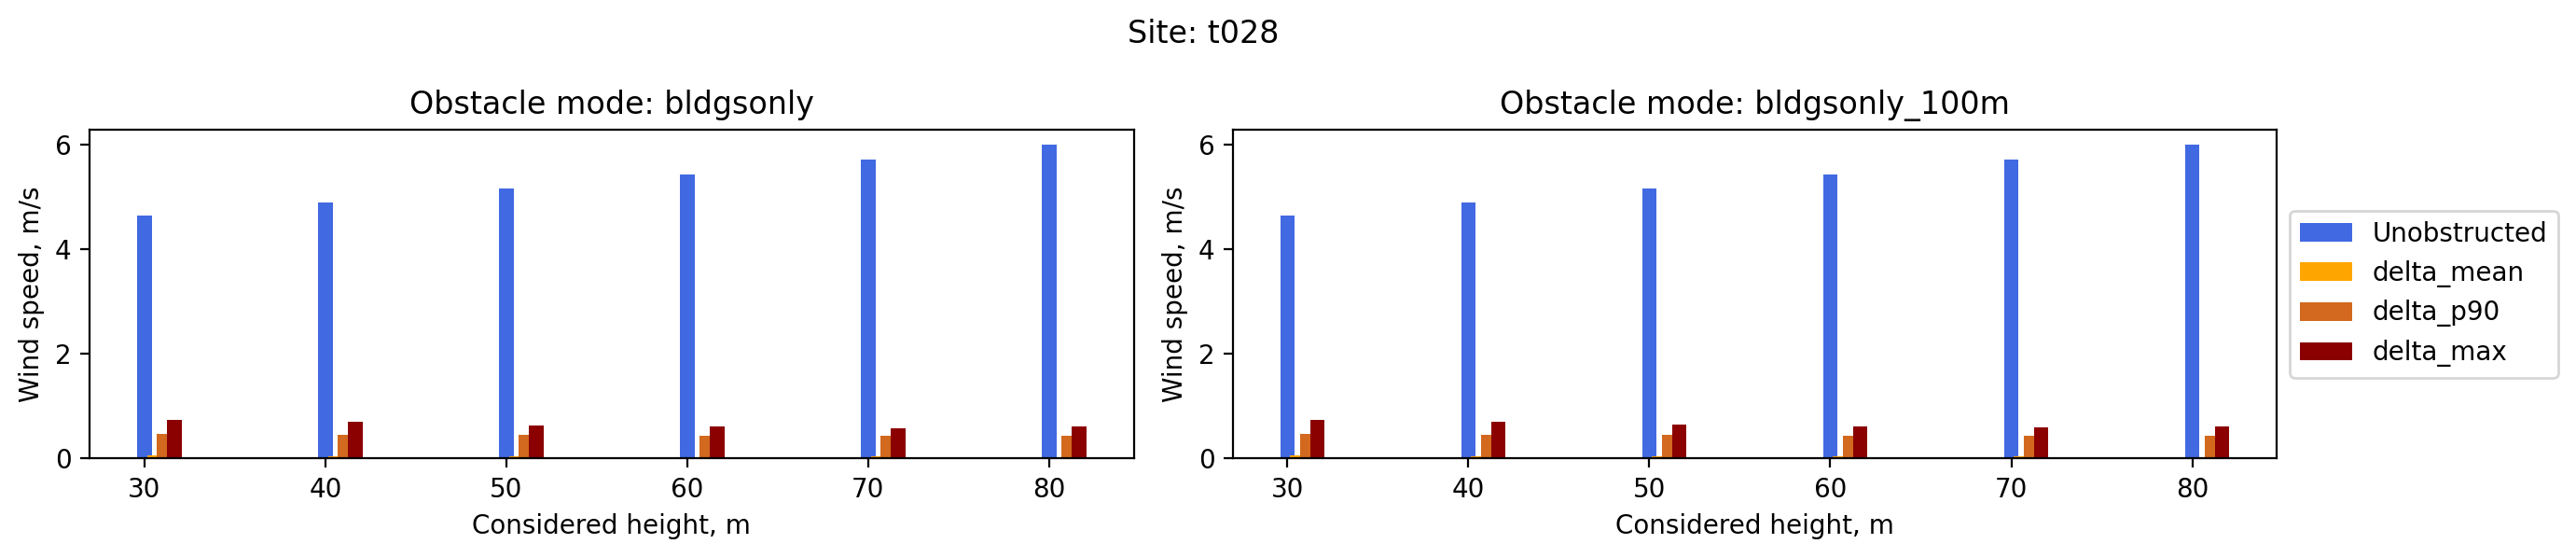

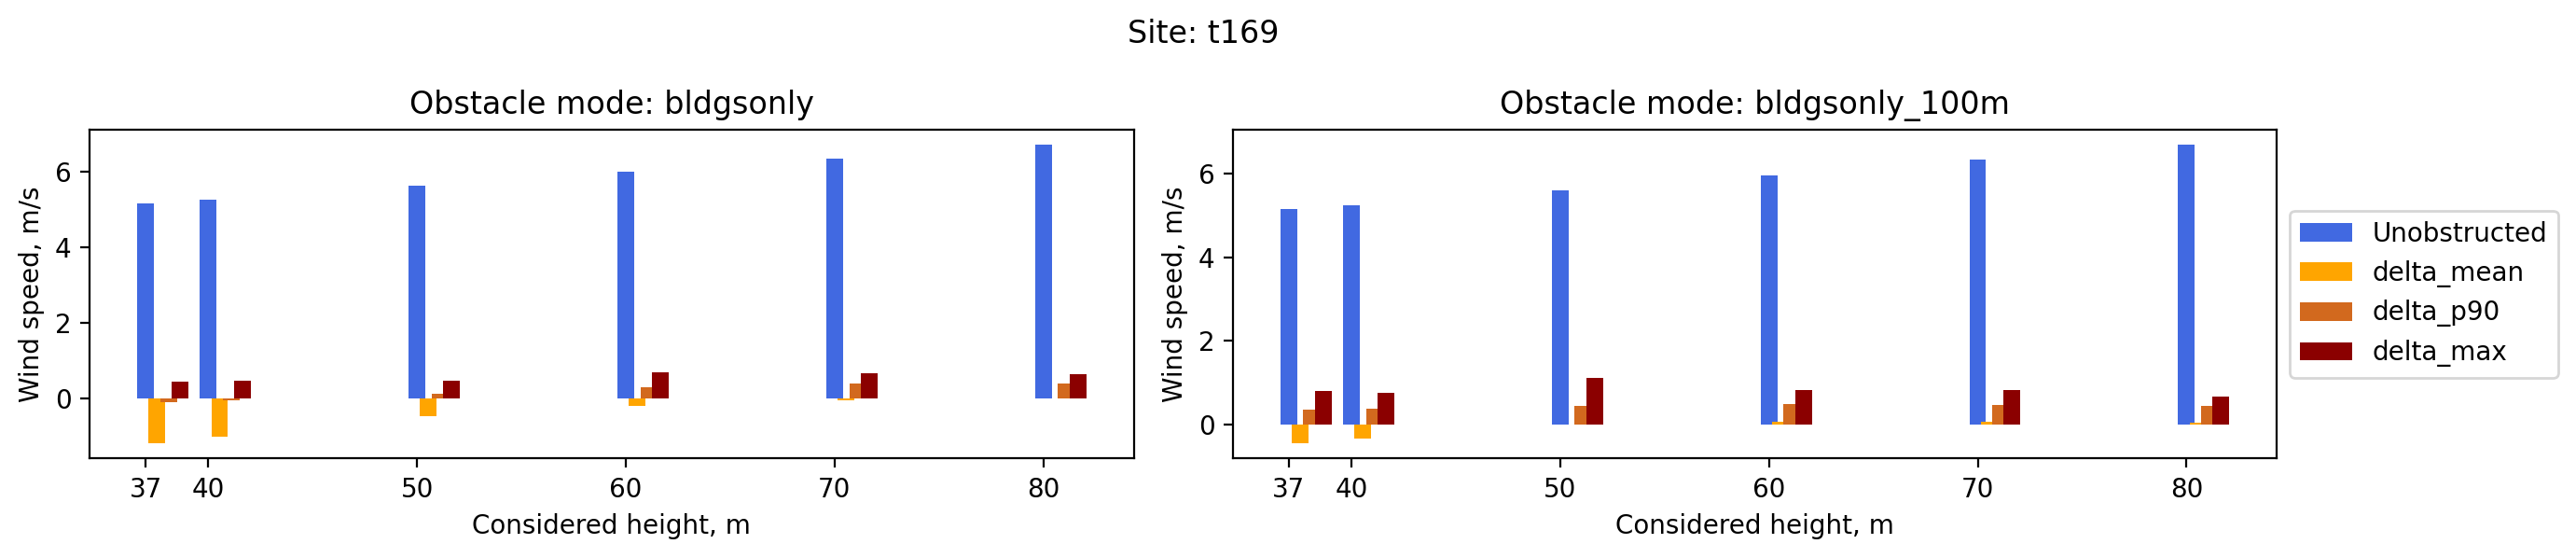

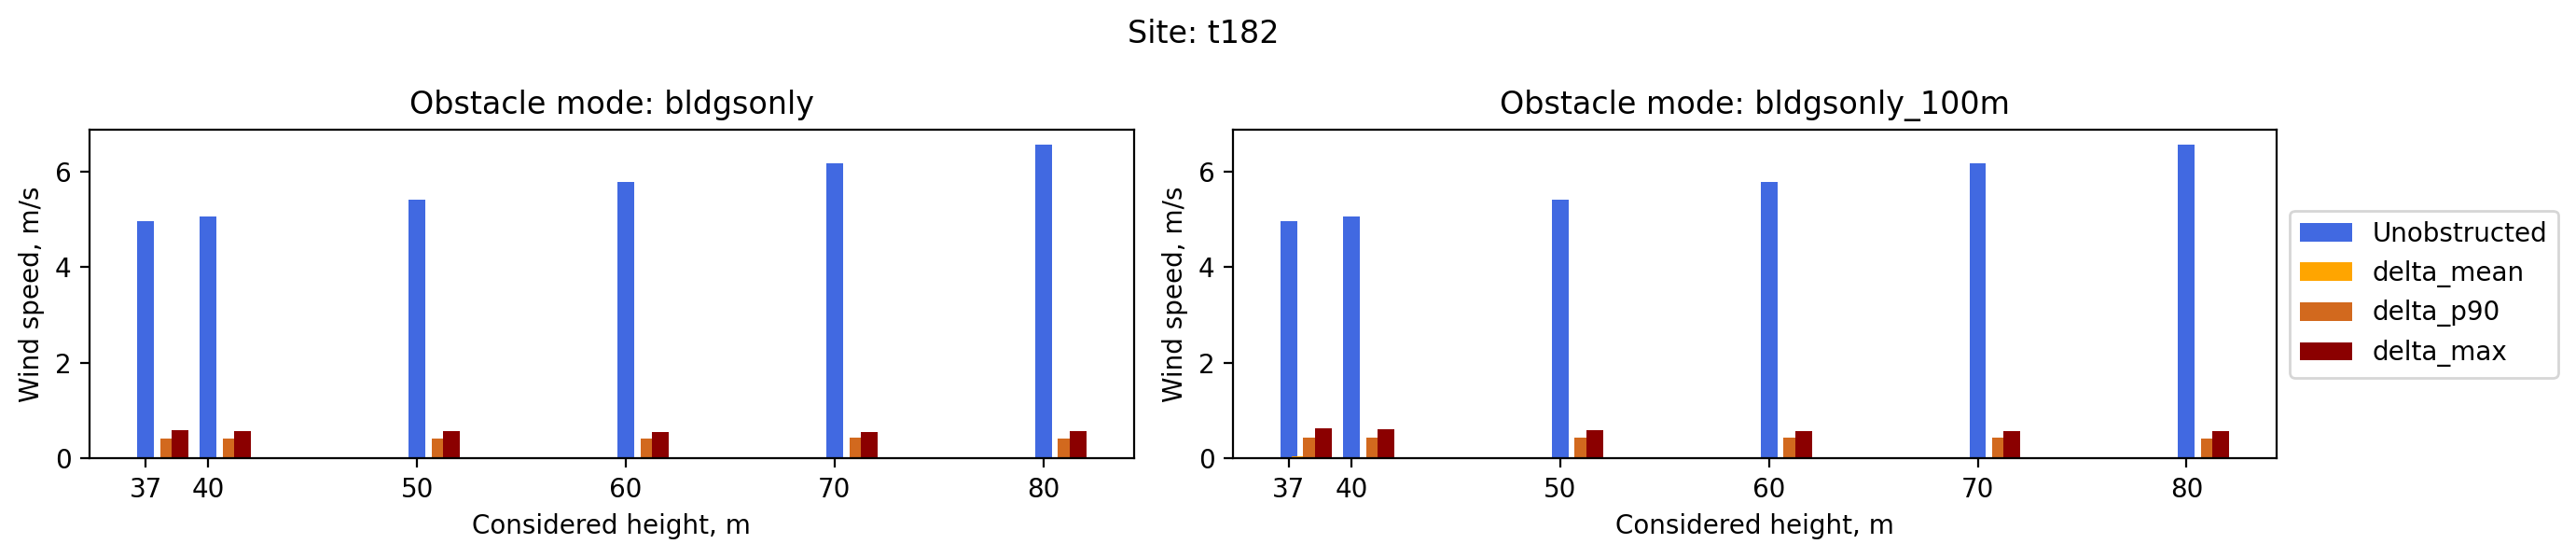

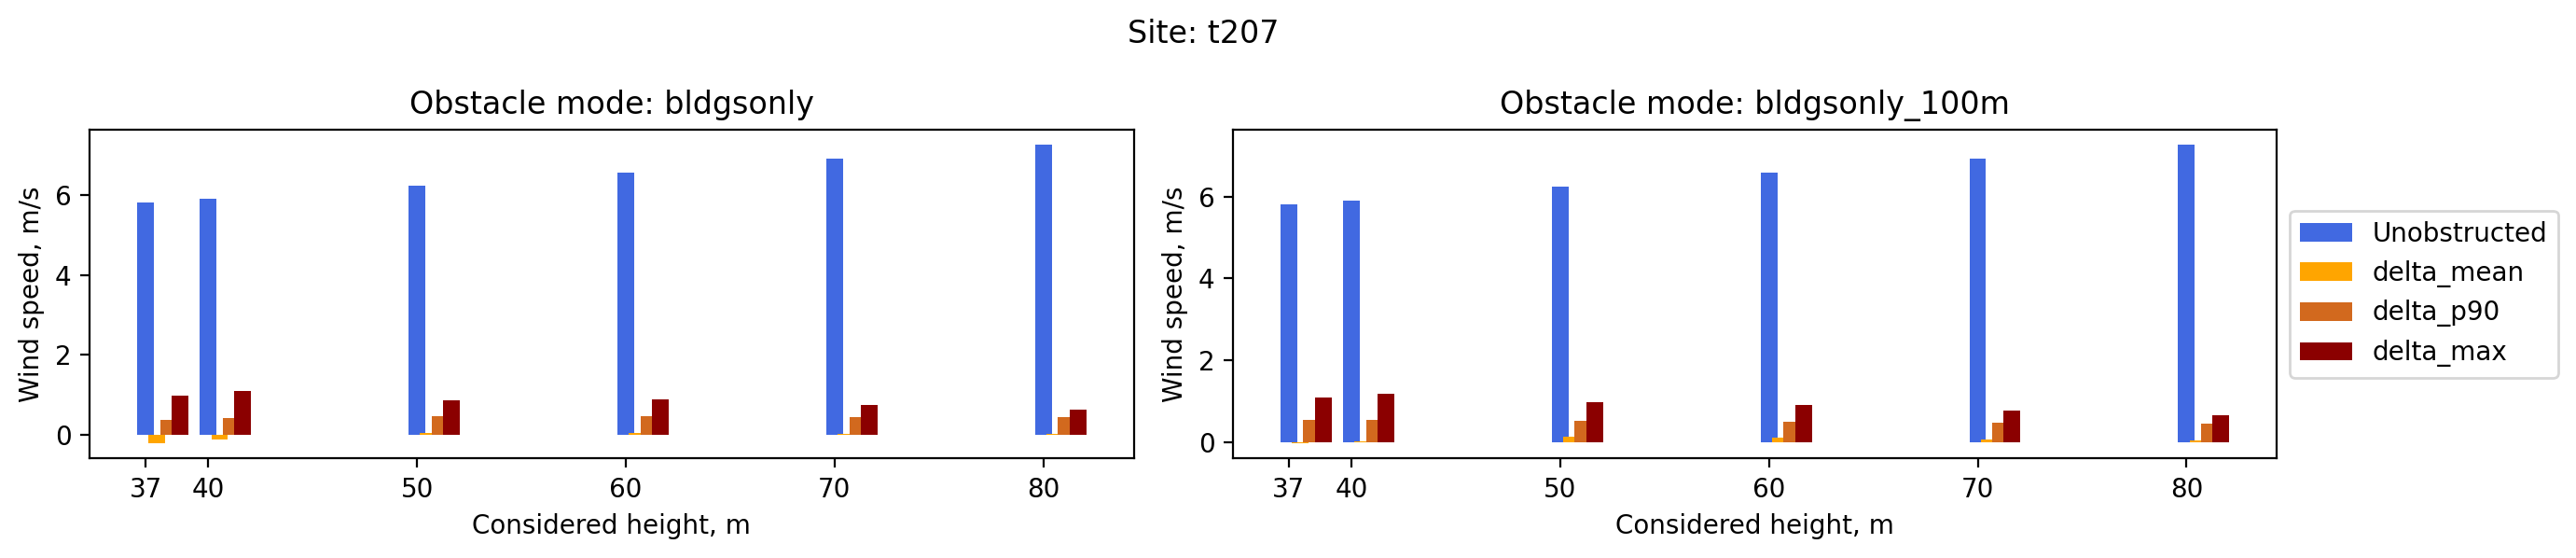

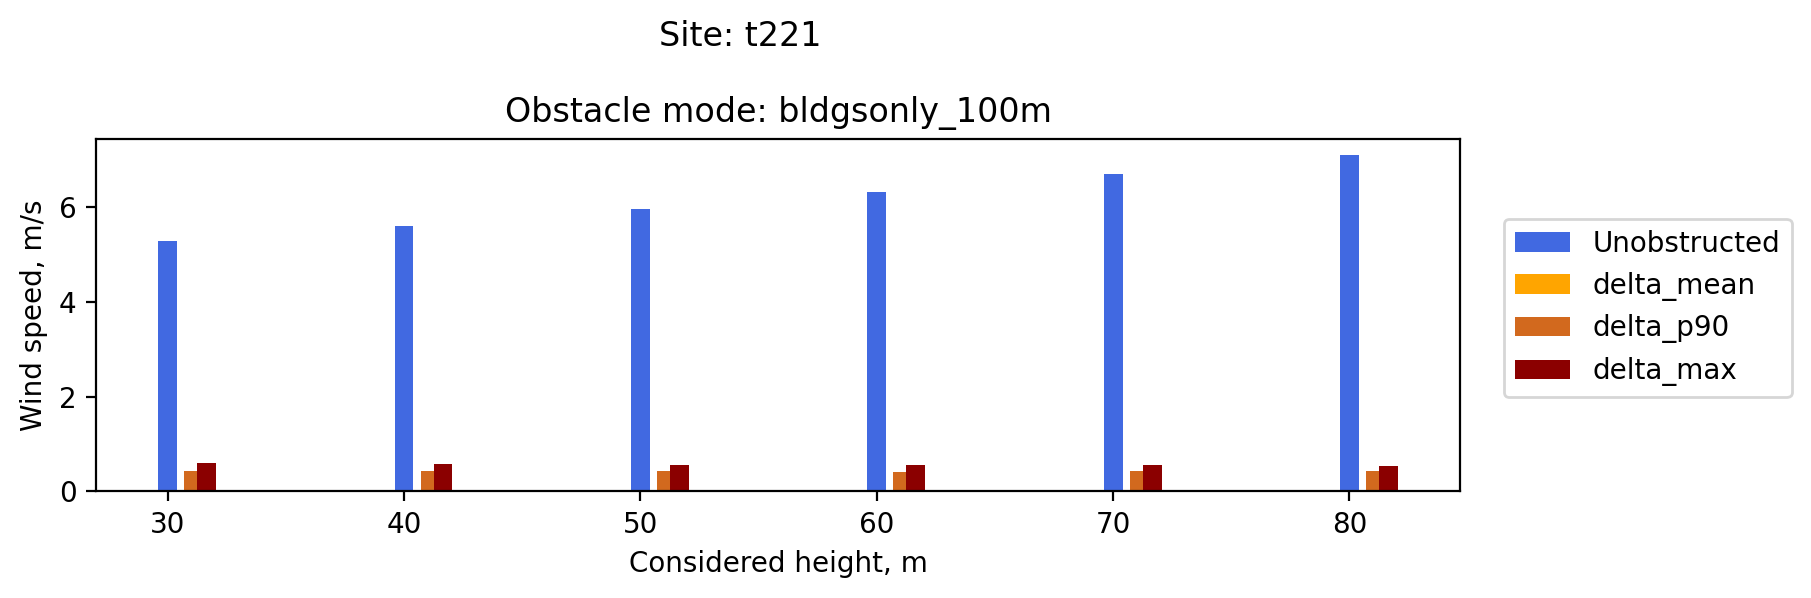

In [30]:
for tid, grp in summary_df.groupby("tid"):
    #print(grp)
    
    if grp.obstacle_mode.nunique() == 2:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,3))
        fig.suptitle("Site: %s" % tid)
        
        bldgsonly_subset = grp[grp["obstacle_mode"] == "bldgsonly"]
        bldgsonly_100m_subset = grp[grp["obstacle_mode"] == "bldgsonly_100m"]
        #print(bldgsonly_subset)
        
        bar_width = 0.55
        
        ax1.bar(bldgsonly_subset.height, bldgsonly_subset["mean(ws)"], color="royalblue")
        ax1.bar(bldgsonly_subset.height+bar_width, bldgsonly_subset["mean(ws_adj-ws)"], color="orange")
        ax1.bar(bldgsonly_subset.height+bar_width*2, bldgsonly_subset["p90(ws_adj-ws)"], color="chocolate")
        ax1.bar(bldgsonly_subset.height+bar_width*3, bldgsonly_subset["max(ws_adj-ws)"], color="darkred")
        ax1.set_title("Obstacle mode: bldgsonly")
        ax1.set_xlabel("Considered height, m")
        ax1.set_ylabel("Wind speed, m/s")
        ax1.set_xticks(sorted(bldgsonly_subset.height))
        
        ax2.bar(bldgsonly_100m_subset.height, bldgsonly_100m_subset["mean(ws)"], color="royalblue", label="Unobstructed")
        ax2.bar(bldgsonly_100m_subset.height+bar_width, bldgsonly_100m_subset["mean(ws_adj-ws)"],  color="orange", label="delta_mean")
        ax2.bar(bldgsonly_100m_subset.height+bar_width*2, bldgsonly_100m_subset["p90(ws_adj-ws)"], color="chocolate", label="delta_p90")
        ax2.bar(bldgsonly_100m_subset.height+bar_width*3, bldgsonly_100m_subset["max(ws_adj-ws)"], color="darkred", label="delta_max")
        ax2.set_title("Obstacle mode: bldgsonly_100m")
        ax2.set_xlabel("Considered height, m")
        ax2.set_ylabel("Wind speed, m/s")
        ax2.set_xticks(sorted(bldgsonly_100m_subset.height))
        
        
        # Shrink current axis by 20%
        box = ax2.get_position()
        ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        plt.tight_layout()
        plt.show()
        
        if tid == "t221":
            display(grp)
    elif grp.obstacle_mode.nunique() == 1:
        fig, ax1 = plt.subplots(1, 1, figsize=(7.5,3))
        fig.suptitle("Site: %s" % tid)
        
        bar_width = 0.55
        
        ax1.bar(grp.height, grp["mean(ws)"], color="royalblue", label="Unobstructed")
        ax1.bar(grp.height+bar_width, grp["mean(ws_adj-ws)"], color="orange", label="delta_mean")
        ax1.bar(grp.height+bar_width*2, grp["p90(ws_adj-ws)"], color="chocolate", label="delta_p90")
        ax1.bar(grp.height+bar_width*3, grp["max(ws_adj-ws)"], color="darkred", label="delta_max")
        
        ax1.set_title("Obstacle mode: bldgsonly_100m")
        ax1.set_xlabel("Considered height, m")
        ax1.set_ylabel("Wind speed, m/s")
        
        # Shrink current axis by 20%
        box = ax1.get_position()
        ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        plt.tight_layout()
        plt.show()
        

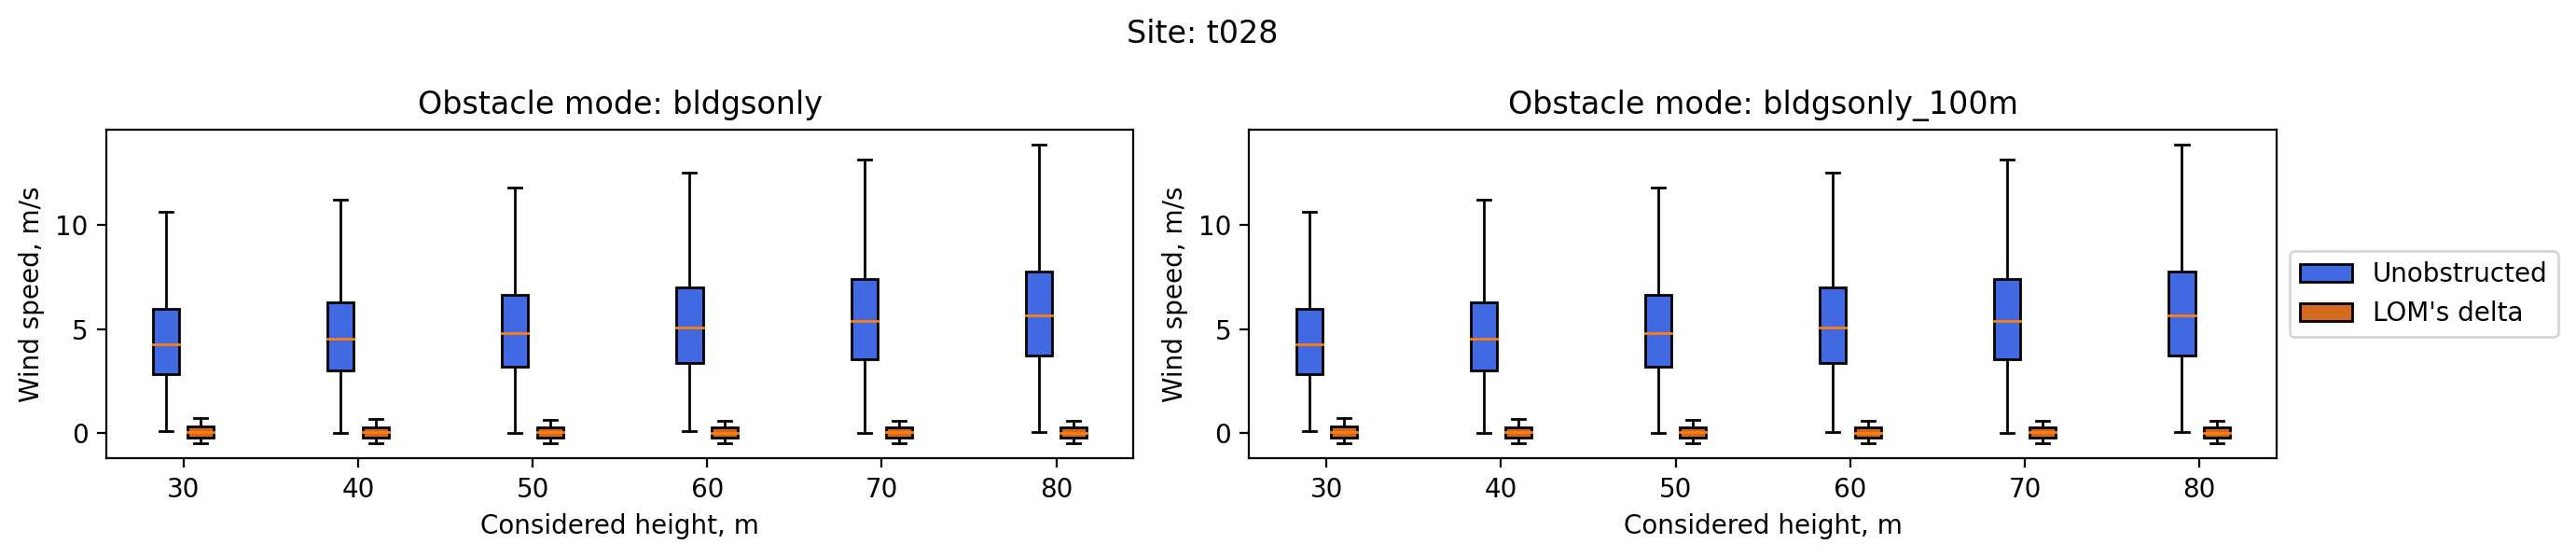

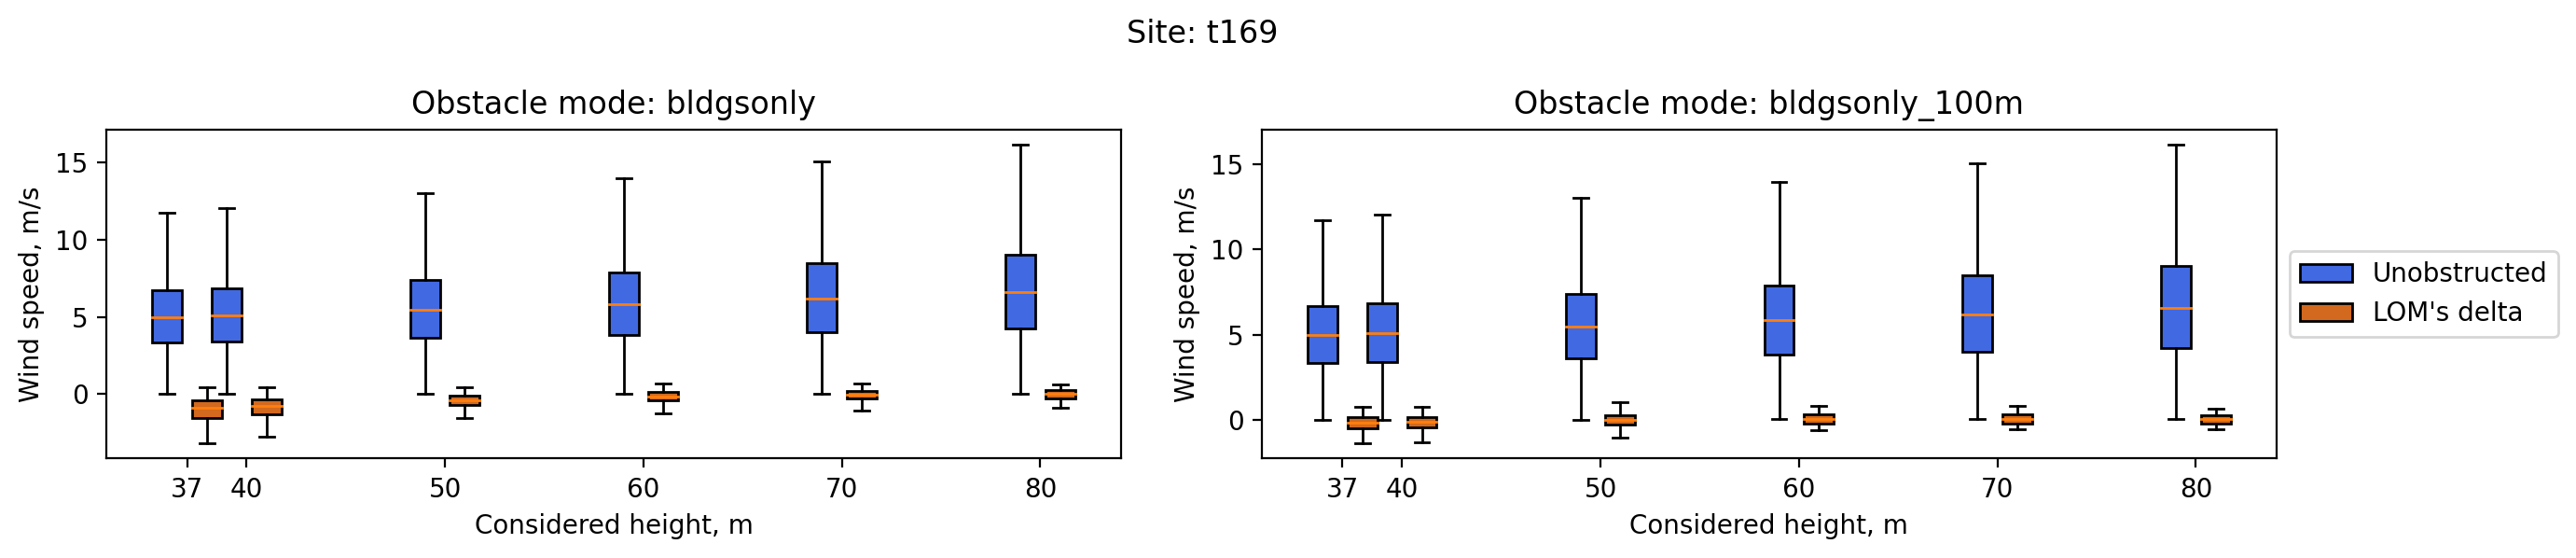

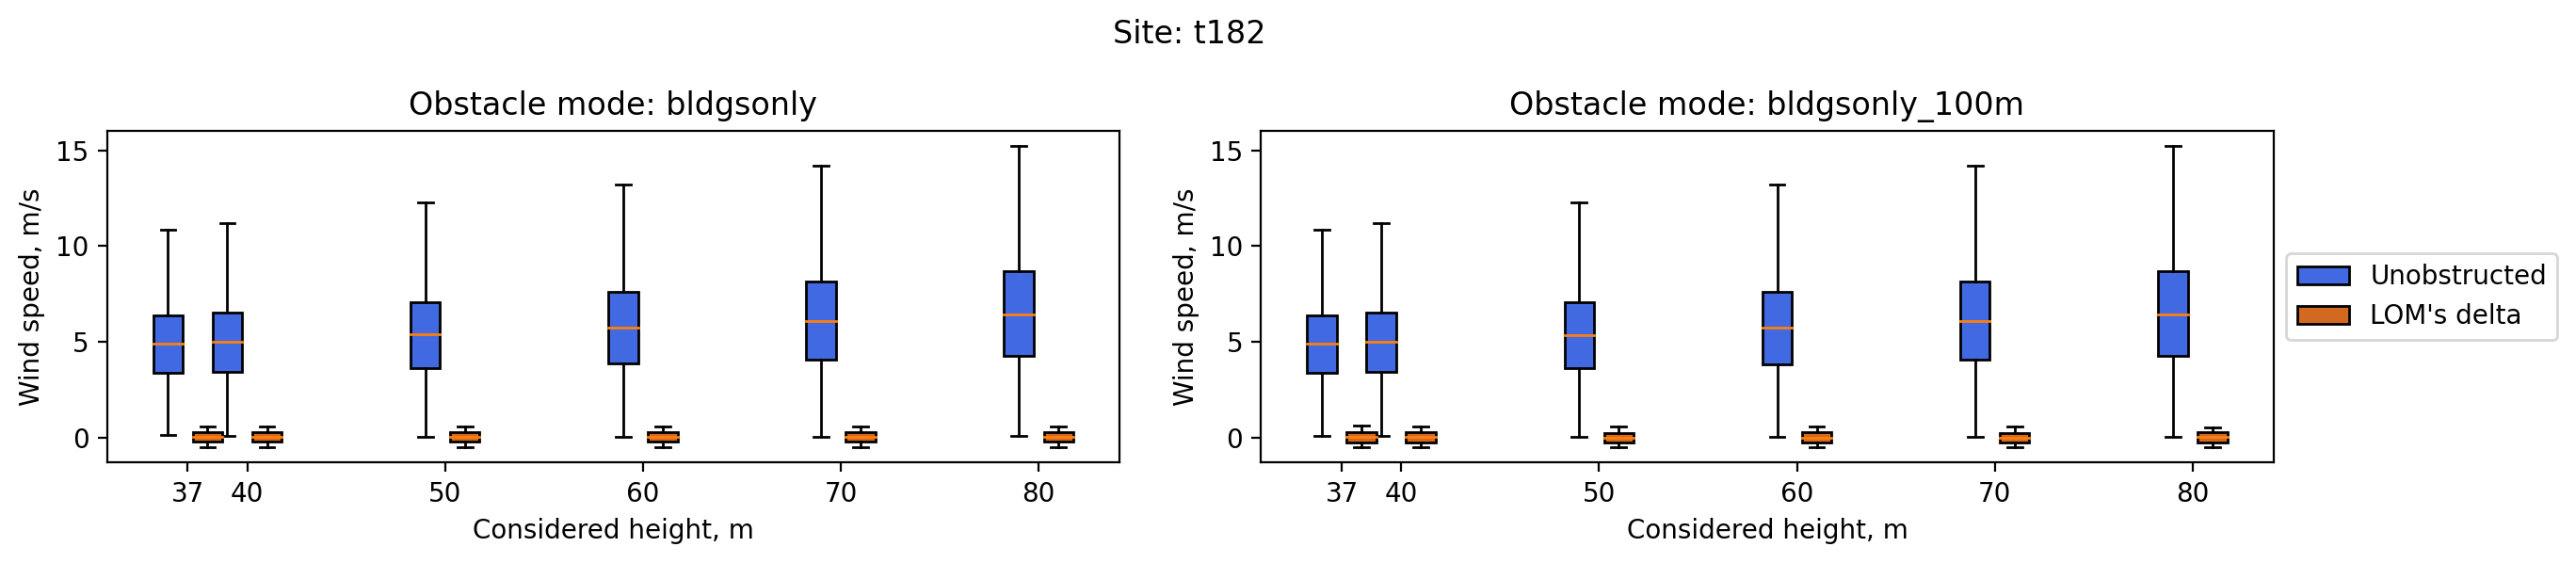

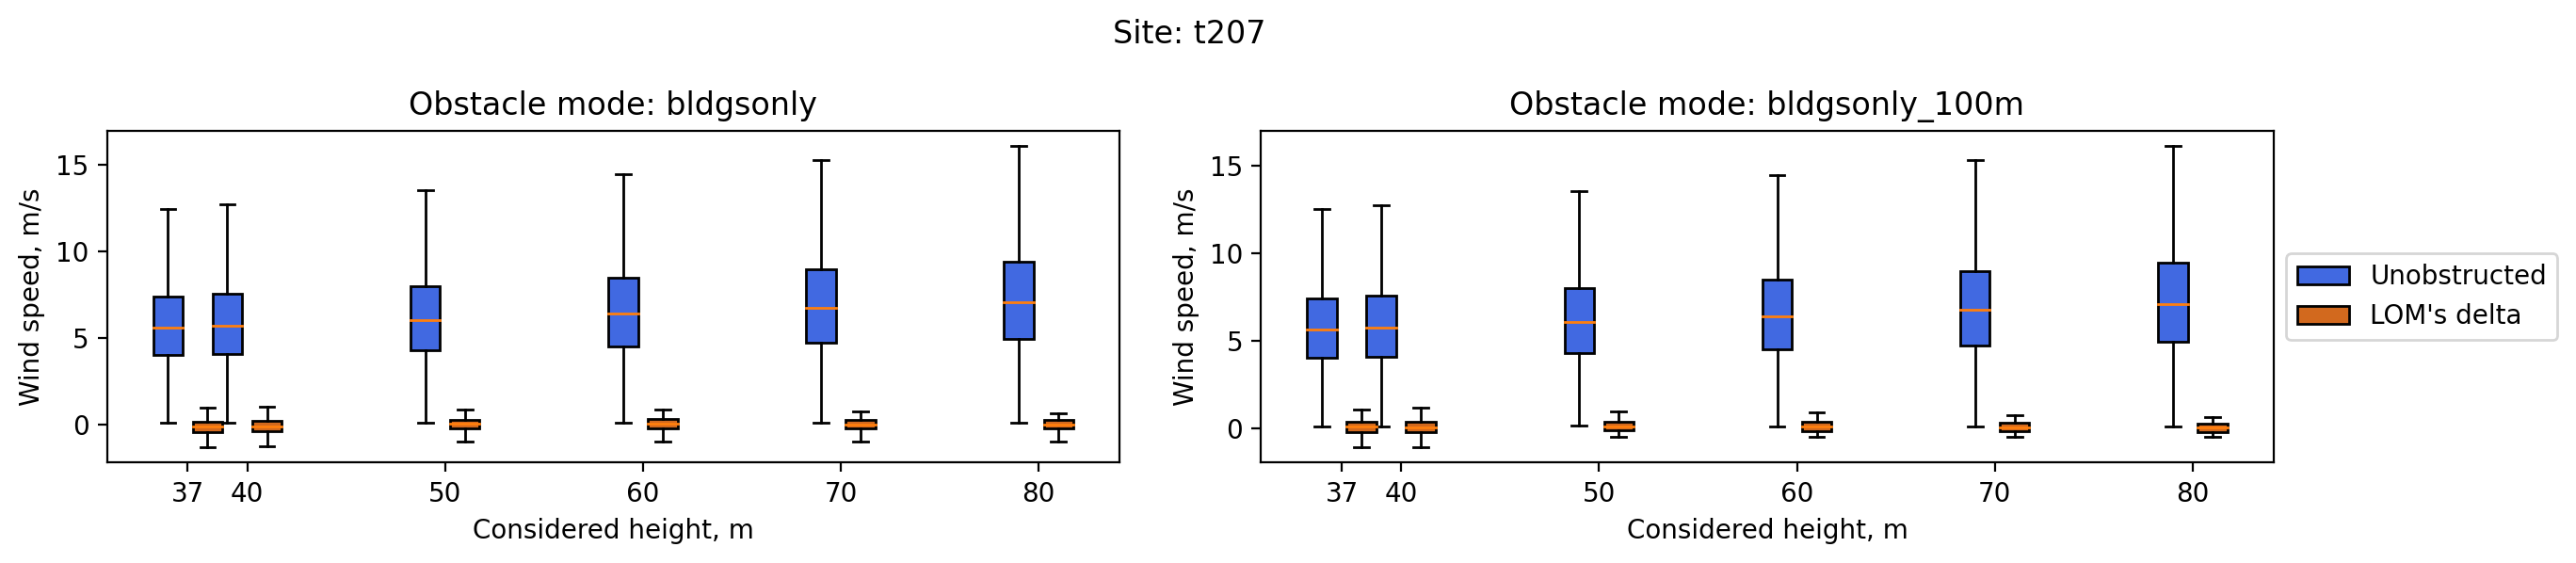

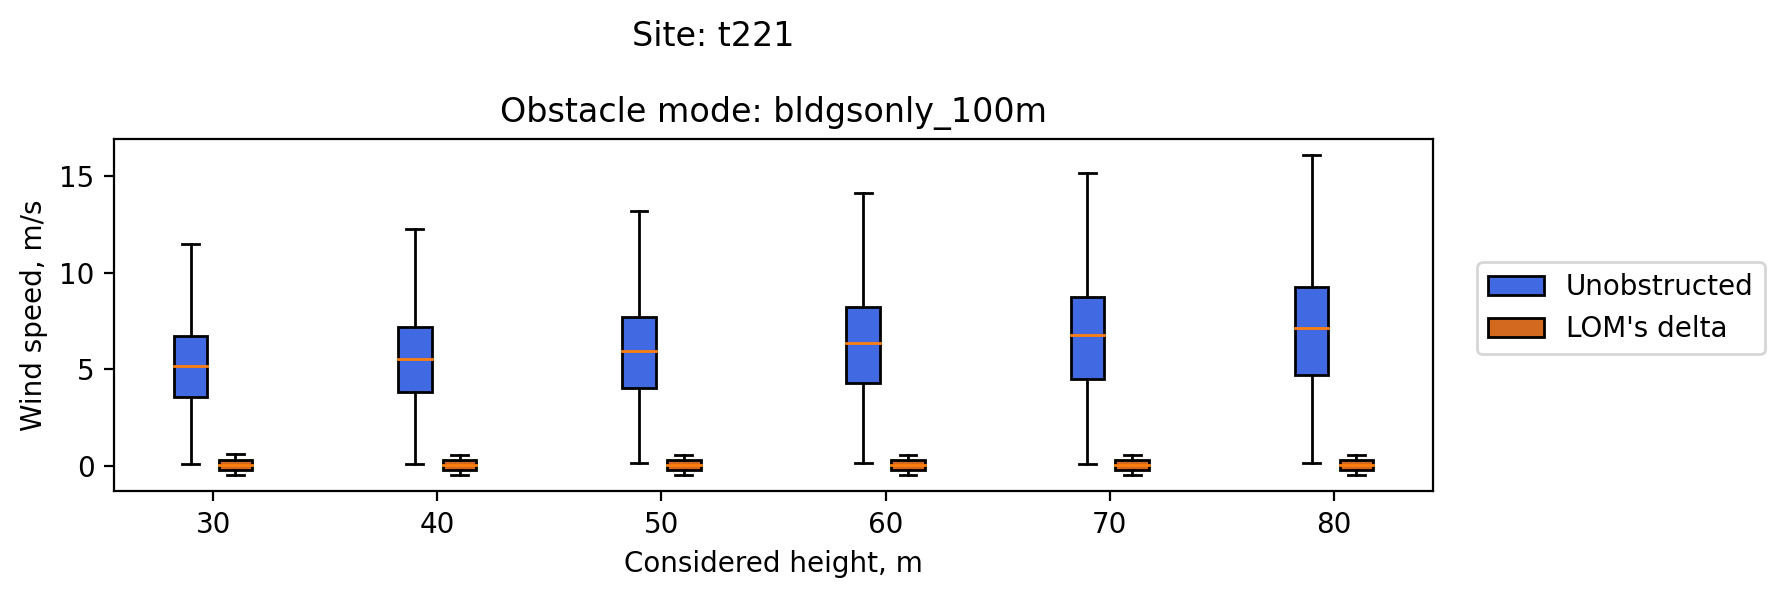

In [71]:
# The same data, different vis

output_dest = "03 Model Outputs/h_analysis/figures"

for tid, grp in summary_df.groupby("tid"):
    #print(grp)
    
    if grp.obstacle_mode.nunique() == 2:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,3))
        fig.suptitle("Site: %s" % tid)
        
        bldgsonly_subset = grp[grp["obstacle_mode"] == "bldgsonly"]
        bldgsonly_100m_subset = grp[grp["obstacle_mode"] == "bldgsonly_100m"]
        #print(bldgsonly_subset)

        heights = sorted(bldgsonly_subset.height)
        x_offset = 2.0
        
        subset_list = []
        for height in heights:
            subset = combined_df[(combined_df["tid"]==tid) & (combined_df["obstacle_mode"]=="bldgsonly") & \
                                 (combined_df["height"]==height)]
            subset_list.append(subset["ws"].tolist())   
        ax1.boxplot(subset_list, 0, '', positions=heights, widths=1.5,                     
                    patch_artist = True,
                    boxprops = dict(facecolor = "royalblue"))
        
        subset_list = []
        for height in heights:
            subset = combined_df[(combined_df["tid"]==tid) & (combined_df["obstacle_mode"]=="bldgsonly") & \
                                 (combined_df["height"]==height)]
            subset_list.append((subset["ws-adjusted"] - subset["ws"]).tolist())    
        
        ax1.boxplot(subset_list, 0, '', positions=np.array(heights) + x_offset, widths=1.5, 
                    patch_artist = True,
                    boxprops = dict(facecolor = "chocolate"))

        ax1.set_title("Obstacle mode: bldgsonly")
        ax1.set_xlabel("Considered height, m")
        ax1.set_ylabel("Wind speed, m/s")
        ax1.set_xticks([x + x_offset/2.0 for x in heights], heights)
        
        
        subset_list = []
        for height in heights:
            subset = combined_df[(combined_df["tid"]==tid) & (combined_df["obstacle_mode"]=="bldgsonly_100m") & \
                                 (combined_df["height"]==height)]
            subset_list.append(subset["ws"].tolist())   
        bp1 = ax2.boxplot(subset_list, 0, '', positions=heights, widths=1.5,                     
                    patch_artist = True,
                    boxprops = dict(facecolor = "royalblue"))
        
        subset_list = []
        for height in heights:
            subset = combined_df[(combined_df["tid"]==tid) & (combined_df["obstacle_mode"]=="bldgsonly_100m") & \
                                 (combined_df["height"]==height)]
            subset_list.append((subset["ws-adjusted"] - subset["ws"]).tolist())    
            
        bp2 = ax2.boxplot(subset_list, 0, '', positions=np.array(heights) + x_offset, widths=1.5, 
                    patch_artist = True,
                    boxprops = dict(facecolor = "chocolate"))
        
        ax2.set_title("Obstacle mode: bldgsonly_100m")
        ax2.set_xlabel("Considered height, m")
        ax2.set_ylabel("Wind speed, m/s")
        ax2.set_xticks([x + x_offset/2.0 for x in heights], heights)
        
        
        # Shrink current axis by 20%
        box = ax2.get_position()
        ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        lgd=ax2.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Unobstructed', "LOM's delta"], \
                   loc='center left', bbox_to_anchor=(1, 0.5))
        
        plt.tight_layout()
        plt.savefig("%s/lanl_%s.png" % (output_dest, tid), dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
        plt.show()
        
        if tid == "t221":
            display(grp)
    elif grp.obstacle_mode.nunique() == 1:
        
        # Special case, t221, where bldgsonly mode errored out and we only show bldgsonly_100m case
        
        fig, ax1 = plt.subplots(1, 1, figsize=(7.5,3))
        fig.suptitle("Site: %s" % tid)
        
        heights = sorted(grp.height)
        x_offset = 2.0
        
        subset_list = []
        for height in heights:
            subset = combined_df[(combined_df["tid"]==tid) & (combined_df["obstacle_mode"]=="bldgsonly_100m") & \
                                 (combined_df["height"]==height)]
            subset_list.append(subset["ws"].tolist())   
        bp1 = ax1.boxplot(subset_list, 0, '', positions=heights, widths=1.5,                     
                    patch_artist = True,
                    boxprops = dict(facecolor = "royalblue"))
        
        subset_list = []
        for height in heights:
            subset = combined_df[(combined_df["tid"]==tid) & (combined_df["obstacle_mode"]=="bldgsonly_100m") & \
                                 (combined_df["height"]==height)]
            subset_list.append((subset["ws-adjusted"] - subset["ws"]).tolist())    
        
        bp2 = ax1.boxplot(subset_list, 0, '', positions=np.array(heights) + x_offset, widths=1.5, 
                    patch_artist = True,
                    boxprops = dict(facecolor = "chocolate"))
        
        ax1.set_title("Obstacle mode: bldgsonly_100m")
        ax1.set_xlabel("Considered height, m")
        ax1.set_ylabel("Wind speed, m/s")
        ax1.set_xticks([x + x_offset/2.0 for x in heights], heights)
        
        # Shrink current axis by 20%
        box = ax1.get_position()
        ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        lgd=fig.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Unobstructed', "LOM's delta"], \
                   loc='center left', bbox_to_anchor=(1, 0.5))
        
        plt.tight_layout()
        plt.savefig("%s/lanl_%s.png" % (output_dest, tid), dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
        plt.show()

In [22]:
# Quick vis of data in produced files

# for f in glob.iglob("%s/*" % dest_dir):
#     df = pd.read_csv(f)
#     fig = plt.gcf()
#     fig.set_size_inches(2.5,2.5)
#     sns.scatterplot(x=df["ws"], \
#                     y=df["ws-adjusted"], alpha=0.2).set(title=os.path.basename(f));
#     plt.show()